## Investigating Data Distribution

**Author:** Shaun Khoo    
**Date:** 11 Oct 2021  
**Context:** Data distribution looks quite skewed from a preliminary look, need to quantify how seriously imbalanced the data distribution is. This has important implications for model training as well as the theoretical upper-limit for our model performance.  
**Objective:** Measure how much coverage (how many SSOCs we have training samples for) we have in the dataset.  

#### A) Set options and import data

In [1]:
import os
os.chdir('..')

In [2]:
import pandas as pd
pd.options.display.max_rows = 100

In [3]:
import plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets
import numpy as np
py.offline.init_notebook_mode(connected = True)

In [3]:
data = pd.read_csv('Data/Processed/Training/train-aws/train_full.csv')
SSOC_2020 = pd.read_csv('Data/Processed/Training/train-aws/SSOC_2020.csv')

In [13]:
# with open('ssoc_autocoder/sentaugment/data/keys.txt', 'w') as f:
#     for item in data['Cleaned_Description']:
#         f.write("%s\n" % ''.join([i if ord(i) < 128 else ' ' for i in item]))

In [23]:
data[data['Cleaned_Description'].str.contains('ry level candidates are welcome to apply, training will be provided. Handle full set of accounts including cash flow, month-end closing, and year-end audit activities. Perform accurate data entry to computerized accounting systems. Prepare full set of accounts and bank reconciliation. Prepare necessary accounting schedules: Fixed assets, prepayments, accruals, loan, hire purchase, etc. Responsible for ad-hoc invoicing and accounting functions. Other Ad-hoc duties or assignments.')]

,Description,SSOC 2020,Cleaned_Description
25490,<ul>\n <li><strong>Working Location: Bukit Ba...,43112,Possess with Diploma / Degree in Accountancy r...


In [24]:
item = data.loc[25490, 'Cleaned_Description']
''.join([i if ord(i) < 128 else ' ' for i in item])

'Possess with Diploma / Degree in Accountancy related field. Prefer to have 1 - 2 years working experiences. Entry level candidates are welcome to apply, training will be provided. Handle full set of accounts including cash flow, month-end closing, and year-end audit activities. Perform accurate data entry to computerized accounting systems. Prepare full set of accounts and bank reconciliation. Prepare necessary accounting schedules: Fixed assets, prepayments, accruals, loan, hire purchase, etc. Responsible for ad-hoc invoicing and accounting functions. Other Ad-hoc duties or assignments.'

In [5]:
mcf_final = pd.read_csv('Data/Processed/MCF_Training_Set_Full.csv', low_memory = False)
original_ssocs = pd.read_csv('Data/Processed/Original SSOCs.csv', low_memory = False)

#### Quick rehash

1D SSOC breakdown:

* 1: Legislators, Senior Officials and Managers
* 2: Professionals
* 3: Associate Professionals and Technicians
* 4: Clerical Support Workers
* 5: Service and Sales Workersd
* 6: Agricultural and Fishery Workers
* 7: Craftsmen and Related Trades Workers
* 8: Plant and Machine Operators and Assemblers
* 9: Cleaners, Labourers and Related Workers

#### B) Basic data investigation

Distribution of 1D SSOCs highly skewed to 1, 2, and 3 (managers and professionals). 6 (agri and fishery workers) is almost non-existent.

In [6]:
data['SSOC 2020'].astype('str').str.slice(0, 1).value_counts()

2    15882
3     9306
1     7807
4     4039
5     2054
8     1643
9     1103
7     1001
6        7
Name: SSOC 2020, dtype: int64

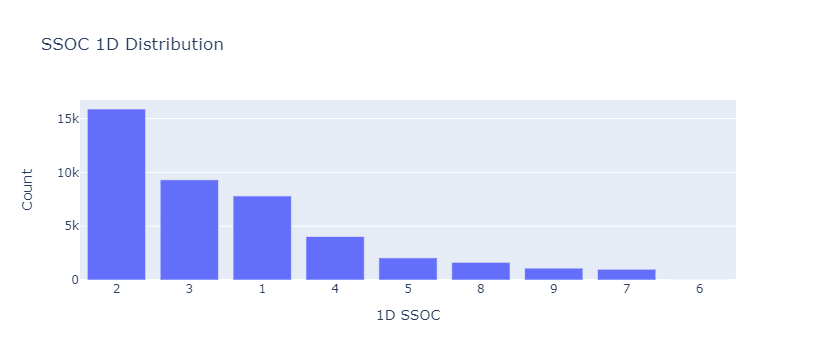

In [7]:
SSOC_1D_count_filt = data['SSOC 2020'].astype('str').str.slice(0, 1).value_counts().filter(regex='\\d')

layout = go.Layout(
    title = 'SSOC 1D Distribution',
    yaxis = dict(
        title = 'Count'
    ),
    xaxis = dict(
        title = '1D SSOC'
    )
)

trace1 = go.Bar(
    x = SSOC_1D_count_filt.index,
    y = SSOC_1D_count_filt.values,
    hovertext = [f'1D SSOC: {index} <br> Count: {count}' for count, index in zip(SSOC_1D_count_filt.values, SSOC_1D_count_filt.index)]
)


fig = go.Figure(data = [trace1], layout = layout)
#py.offline.iplot(fig)
fig.show()

Of the top 5 most common SSOCs, 4 of them are "others" categories. This is not very useful for us.

* 21499: Other engineering professionals n.e.c
* 33499: Other administrative and related associate professionals n.e.c
* 13499: Other professional, financial, community, and social services managers n.e.c
* 25121: Software developer
* 41109: Other administrative clerks (e.g. public relations clerk)

In [8]:
commonSSOC = data['SSOC 2020'].astype('str').str.slice(0, 5).value_counts().sort_values(ascending = False).head(10)

In [9]:
top5_filt_ssoc = SSOC_2020[SSOC_2020['SSOC 2020'].astype('str').isin(commonSSOC.index)]
top5_filt_ssoc['Count'] = top5_filt_ssoc['SSOC 2020'].apply(lambda x: commonSSOC.loc[str(x)])
top5_filt_ssoc = top5_filt_ssoc.sort_values('Count', ascending = False)

C:\Users\shaun\AppData\Local\Temp/ipykernel_12336/3340815073.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



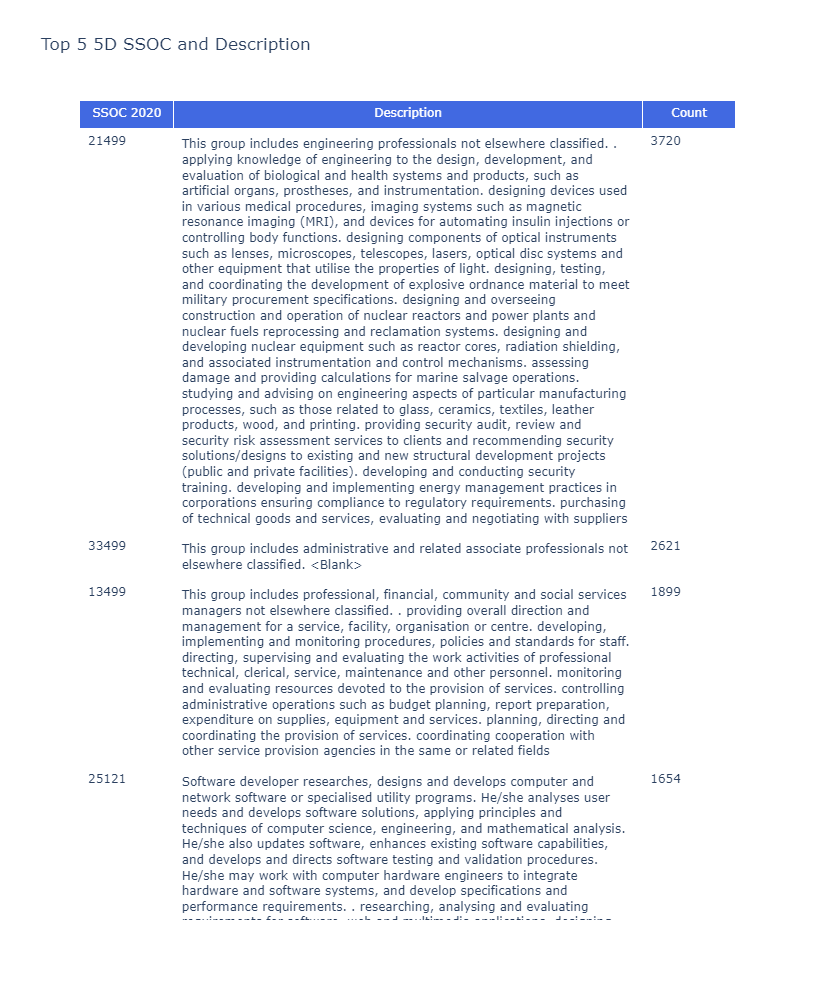

In [10]:
layout2 = go.Layout(
    title = 'Top 5 5D SSOC and Description',
    height=1000
    
)

trace2 = go.Table(
    columnwidth = [80,400,80],
    header = dict(
        values = list(top5_filt_ssoc.columns),
        fill_color = 'royalblue',
        align = 'center',
        font=dict(color='white', size=12)
    ),
    cells = dict(
        values = [top5_filt_ssoc['SSOC 2020'], top5_filt_ssoc['Description'], top5_filt_ssoc['Count']],
        fill_color = 'white',
        align = 'left'
    )
)


fig2 = go.Figure(data = [trace2], layout = layout2)
py.offline.iplot(fig2)

There are 583 SSOCs that are not featured at all in our current dataset (with predictions). This represents more than half of the available SSOCs, which will be problematic for us when trying to finetune the data.

In [17]:
SSOC_2020['SSOC 2020'] = SSOC_2020['SSOC 2020'].astype('str')
data['SSOC 2020'] = data['SSOC 2020'].astype('str')
SSOC_2020_counts = SSOC_2020.merge(data.groupby('SSOC 2020').count()['Cleaned_Description'].reset_index(),
                                   on = 'SSOC 2020',
                                   how = 'left').fillna(0)
SSOC_2020_counts.columns = ['SSOC 2020', 'Description', 'Predicted_Count']

In [18]:
print(f"Number of SSOCs with 0 counts: {len(SSOC_2020_counts[SSOC_2020_counts['Predicted_Count'] == 0])}")
print(f"Number of SSOCs with <10 counts: {len(SSOC_2020_counts[SSOC_2020_counts['Predicted_Count'] < 10])}")

Number of SSOCs with 0 counts: 583
Number of SSOCs with <10 counts: 730


In [19]:
SSOC_2020_counts['1D'] = SSOC_2020_counts['SSOC 2020'].apply(lambda x: x[0:1])
SSOC_2020_counts['Remaining_D'] = SSOC_2020_counts['SSOC 2020'].apply(lambda x: x[1:])
SSOC_2020_counts['Log_Predicted_Count'] = SSOC_2020_counts['Predicted_Count'].apply(lambda x: np.log2(x) if x != 0 else 0 )

Dark blue grids represents a lack of entries for the corresponding SSOC.

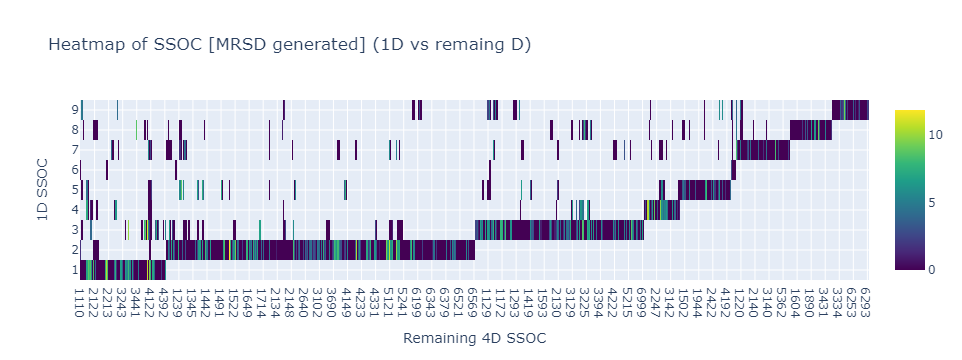

In [20]:
layout3 = go.Layout(
    title = 'Heatmap of SSOC [MRSD generated] (1D vs remaing D)',
    yaxis = dict(
        title = '1D SSOC'
    ),
    xaxis = dict(
        title = 'Remaining 4D SSOC'
    )
)

trace3 = go.Heatmap(
    z = SSOC_2020_counts.Log_Predicted_Count,
    x = SSOC_2020_counts.Remaining_D,
    y = SSOC_2020_counts['1D'],
    customdata = SSOC_2020_counts.Predicted_Count,
    hovertemplate='1D SSOC: %{x}<br>Remaining 4D SSOC: %{y}<br>Count: %{customdata}<extra></extra>',
    colorscale='Viridis'
)


fig3 = go.Figure(data = [trace3], layout = layout3)
py.offline.iplot(fig3)

This is unfortunately only slightly worse than the declared SSOCs, with 464 SSOCs not being featured at all.

In [21]:
#original_ssocs = original_ssocs[~original_ssocs['Reported_SSOC_2020'].str.contains('X')]
original_ssocs['Reported_SSOC_2020'] = original_ssocs['Reported_SSOC_2020'].astype('str')
data_w_original = pd.concat([data, mcf_final[['MCF_Job_Ad_ID']]], axis = 1).merge(original_ssocs,
                                                                                  on = 'MCF_Job_Ad_ID',
                                                                                  how = 'left')

In [22]:
SSOC_2020_counts = SSOC_2020_counts[['SSOC 2020']]

In [23]:
SSOC_2020_counts = SSOC_2020_counts.merge(data_w_original.groupby('Reported_SSOC_2020').count()['Cleaned_Description'].reset_index(),
                                          left_on = 'SSOC 2020',
                                          right_on = 'Reported_SSOC_2020',
                                          how = 'left').fillna(0)
SSOC_2020_counts.drop('Reported_SSOC_2020', axis = 1, inplace = True)
SSOC_2020_counts.columns = ['SSOC 2020', 'Reported_Count']

In [24]:
print(f"Number of SSOCs with 0 counts: {len(SSOC_2020_counts[SSOC_2020_counts['Reported_Count'] == 0])}")
print(f"Number of SSOCs with <10 counts: {len(SSOC_2020_counts[SSOC_2020_counts['Reported_Count'] < 10])}")

Number of SSOCs with 0 counts: 464
Number of SSOCs with <10 counts: 718


Comparing the top 10 SSOCs for both the predicted and reported SSOCs... and there is a clear similarity here.

In [25]:
SSOC_2020_counts['1D'] = SSOC_2020_counts['SSOC 2020'].apply(lambda x: x[0:1])
SSOC_2020_counts['Remaining_D'] = SSOC_2020_counts['SSOC 2020'].apply(lambda x: x[1:])
SSOC_2020_counts['Log_Reported_Count'] = SSOC_2020_counts['Reported_Count'].apply(lambda x: np.log2(x) if x != 0 else 0 )

Observe that the self reported SSOCS also have missing values as well. Therefore, thre is a need to find alternatives to fill up these missing values.

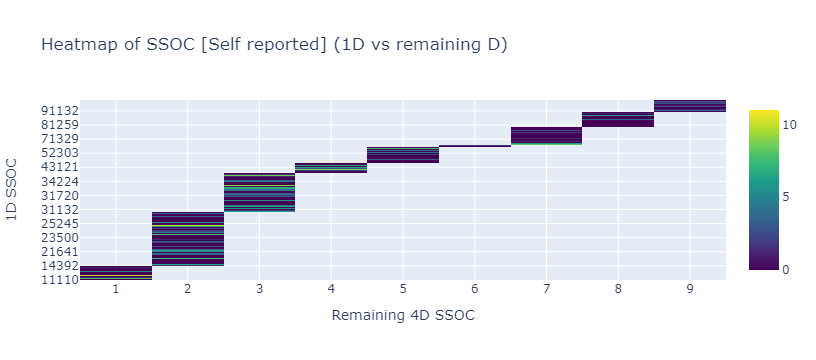

In [32]:
layout4 = go.Layout(
    title = 'Heatmap of SSOC [Self reported] (1D vs remaining D)',
    yaxis = dict(
        title = '1D SSOC'
    ),
    xaxis = dict(
        title = 'Remaining 4D SSOC'
    )
)

trace4 = go.Heatmap(
    z = SSOC_2020_counts.Log_Reported_Count,
    y = SSOC_2020_counts['SSOC 2020'],
    x = SSOC_2020_counts['1D'],
    customdata = SSOC_2020_counts.Reported_Count,
    hovertemplate='1D SSOC: %{x}<br>Remaining 4D SSOC: %{y}<br>Count: %{customdata}<extra></extra>',
    colorscale='Viridis'
)

fig4 = go.Figure(data = [trace4], layout = layout4)
py.offline.iplot(fig4)

In [27]:
data_w_original['Reported_SSOC_2020'].astype('str').str.slice(0, 5).value_counts().sort_values(ascending = False).head(10)

21499    2045
33499    1820
25121    1538
13499    1189
41109    1142
12211    1100
29090    1095
39990    1049
33299     936
24212     865
Name: Reported_SSOC_2020, dtype: int64

In [28]:
data['SSOC 2020'].astype('str').str.slice(0, 5).value_counts().sort_values(ascending = False).head(10)

21499    3720
33499    2621
13499    1899
25121    1654
41109    1512
12211    1490
24212    1273
33299    1001
25190     898
43112     841
Name: SSOC 2020, dtype: int64